In [7]:
import transferboost
from transferboost.dataset import load_data
from transferboost.models import LGBMTransferLearner

import lightgbm as lgb

# Get 
X, y1, y2 = load_data(return_X_y=True)

lgb_model = lgb.LGBMClassifier(
    max_depth = 3,
    reg_lambda = 0,
    num_leaves=5,
    n_estimators=100,
)

lgb_model.fit(X,y1)

t_lgb_model = LGBMTransferLearner(lgb_model)
t_lgb_model.fit(X,y2)
t_lgb_model.predict_proba(X)

array([[0.69039324, 0.30960676],
       [0.92964202, 0.07035798],
       [0.83744304, 0.16255696],
       ...,
       [0.502921  , 0.497079  ],
       [0.81272844, 0.18727156],
       [0.71802491, 0.28197509]])

In [16]:
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(X,y1, test_size=0.33, random_state=42)

y_train_2 = y2.loc[X_train.index]
y_test_2= y2.loc[X_test.index]

502
[11:15:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.81073	validation_0-logloss:0.60129	validation_1-auc:0.80522	validation_1-logloss:0.60215


/Users/sandro/.miniconda/installation/envs/transferboost_dev/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[30]	validation_0-auc:0.90026	validation_0-logloss:0.37932	validation_1-auc:0.88549	validation_1-logloss:0.39476
[60]	validation_0-auc:0.90642	validation_0-logloss:0.36587	validation_1-auc:0.88710	validation_1-logloss:0.39034
[65]	validation_0-auc:0.90748	validation_0-logloss:0.36390	validation_1-auc:0.88726	validation_1-logloss:0.39017
CPU times: user 1.45 s, sys: 32 ms, total: 1.48 s
Wall time: 520 ms


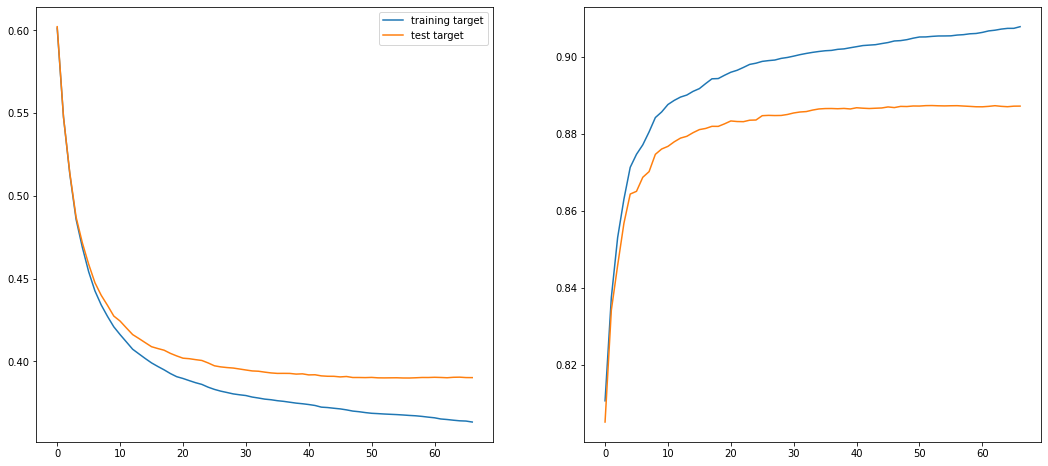

In [18]:
%%time

min_frac =int(0.05*X_train.shape[0])
print(min_frac)

# model = lgb.LGBMClassifier(
#     num_leaves=4,
#     n_estimators=10,
#     min_child_samples=min_frac
# )

xgb_model = xgb.XGBClassifier(
    max_depth = 2,
    reg_lambda = 0,
    num_leaves=4,
    n_estimators=130,
    min_child_samples=min_frac
)

eval_set = [(X_train,y_train_1),(X_test, y_test_1)]

xgb_model.fit(
    X_train,
    y_train_1,
    eval_metric=["auc","logloss"], 
#     eval_names = ['validation_0','validation_1'],
    eval_set=eval_set, 
    verbose=30, # after how many training sets you want the printout on the console
    early_stopping_rounds=10
)

fig, ax = plt.subplots(1,2,figsize=(18,8))


ax[0].plot(xgb_model.evals_result_['validation_0']['logloss'], label = "training target")
ax[0].plot(xgb_model.evals_result_['validation_1']['logloss'], label = "test target")

ax[1].plot(xgb_model.evals_result_['validation_0']['auc'])
ax[1].plot(xgb_model.evals_result_['validation_1']['auc'])
ax[0].legend()



In [ ]:
from tboost.utils.boost import TBoost
import numpy as np

In [ ]:
leaves_train = xgb_model.apply(X_train)
leaves_test = xgb_model.apply(X_test)

In [19]:
from transferboost.models import XGBTransferLearner

In [20]:
xgb_model.objective

'binary:logistic'

In [22]:
# XGBTransferLearner(xgb.XGBRegressor())

In [30]:
xgb_model.n_estimators

130

In [24]:
xgb_tboost = XGBTransferLearner(xgb_model)

In [25]:
xgb_tboost.fit(X_train, y_train_2)

XGBTransferLearner with base model
	XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_samples=502, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=130, n_jobs=4,
              num_leaves=4, num_parallel_tree=1, random_state=0, reg_alpha=0,
              reg_lambda=0, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
base_score = 0.5

In [26]:
probs = xgb_tboost.predict_proba(X_train)

In [38]:
xgb_proba = list()
tb_proba = list()
# for ix_tree in range(1,leaves_train.shape[1]+1):
for ix_tree in range(1,xgb_model.n_estimators+1):
    xgb_proba.append(xgb_model.predict_proba(X_test, ntree_limit = ix_tree)[:,1])
    tb_proba.append(xgb_tboost.predict_proba(X_test, tree_index = ix_tree)[:,1])

In [39]:
from sklearn.metrics import roc_auc_score, log_loss

In [42]:
# tb_proba

In [43]:
auc_xgb_tar_1 = [roc_auc_score(y_test_1,xgb_prob) for xgb_prob in xgb_proba]
auc_xgb_tar_2 = [roc_auc_score(y_test_2,xgb_prob) for xgb_prob in xgb_proba]
auc_tb_tar_2 = [roc_auc_score(y_test_2,tb_prob) for tb_prob in tb_proba]

ll_xgb_tar_1 = [log_loss(y_test_1,xgb_prob) for xgb_prob in xgb_proba]
ll_xgb_tar_2 = [log_loss(y_test_2,xgb_prob) for xgb_prob in xgb_proba]
ll_tb_tar_2 = [log_loss(y_test_2,tb_prob) for tb_prob in tb_proba]

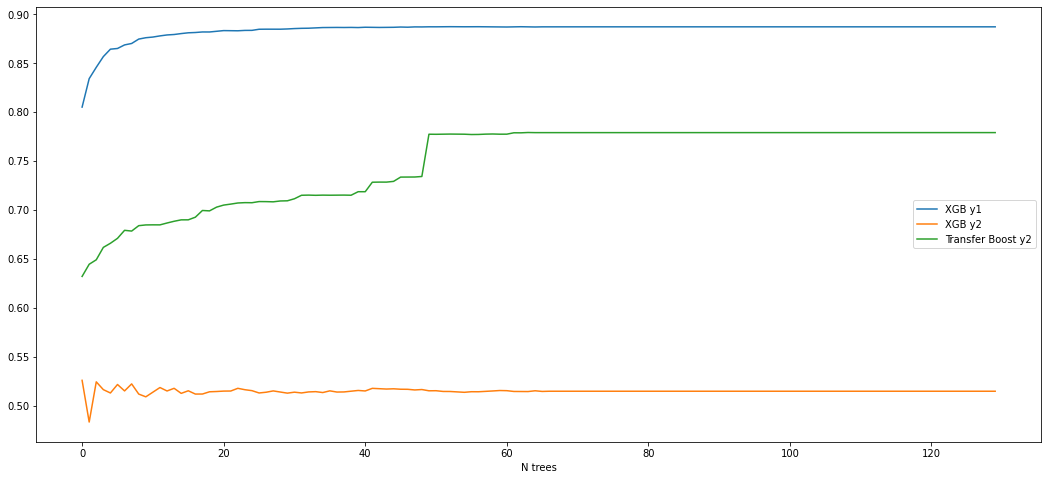

In [44]:
fig, ax = plt.subplots(figsize=(18,8))


ax.plot(auc_xgb_tar_1, label = "XGB y1")
ax.plot(auc_xgb_tar_2, label = "XGB y2")
ax.plot(auc_tb_tar_2, label = "Transfer Boost y2")

ax.set_xlabel("N trees")

ax.legend()

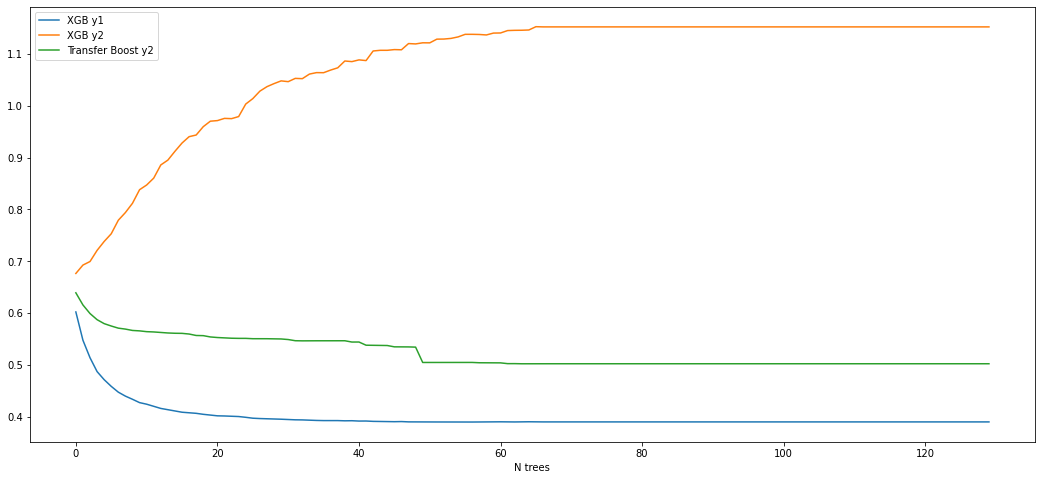

In [45]:
fig, ax = plt.subplots(figsize=(18,8))


ax.plot(ll_xgb_tar_1, label = "XGB y1")
ax.plot(ll_xgb_tar_2, label = "XGB y2")
ax.plot(ll_tb_tar_2, label = "Transfer Boost y2")

ax.set_xlabel("N trees")

ax.legend()

In [ ]:
len(tb_proba)

In [ ]:
tb.leaf_vals_map_

In [ ]:
from tboost.utils import recompute_leaves, compute_probability

In [ ]:
leaves_train = xgb_model.apply(X_train)
leaves_test = xgb_model.apply(X_test)

In [ ]:
transfered_leafs_train, leaves_map = recompute_leaves(leaves_train, X_train, y_train_2, model_params=xgb_model.get_params())

In [ ]:
transfered_leafs_train.shape

In [ ]:
leaves_train.shape

In [ ]:
leaves_train[:,0]

In [ ]:
leaves_map[0]

In [ ]:
compute_probability?

In [ ]:
bst.save_model("test.json")

In [ ]:
bst = xgb_model.get_booster() 

In [ ]:
bst.load_model?

In [ ]:
bst.save_model?